# Data Exploration and Preprocessing and EDA

## Import necessary libraries and packages

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix
warnings.filterwarnings('ignore')
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.datasets import load_hobbies

## Read data into pandas

In [2]:
wiki= pd.read_csv('./data/wiki_movie_plots_deduped.csv')

wiki.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Descriptive Statistics

The release years range from 1901 to 2017 in the dataset

In [3]:
wiki.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


There are 34886 rows and 8 columns 

In [4]:
wiki.shape

(34886, 8)

In [5]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


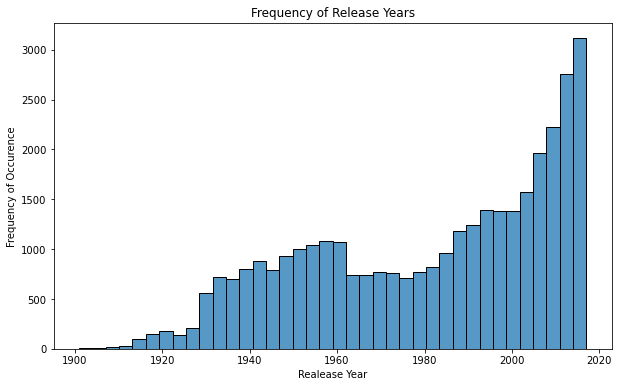

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x = wiki['Release Year'])
plt.title('Frequency of Release Years')
plt.xlabel('Realease Year')
plt.ylabel('Frequency of Occurence')
fig.savefig('./images/freqofreleaseyear.png');

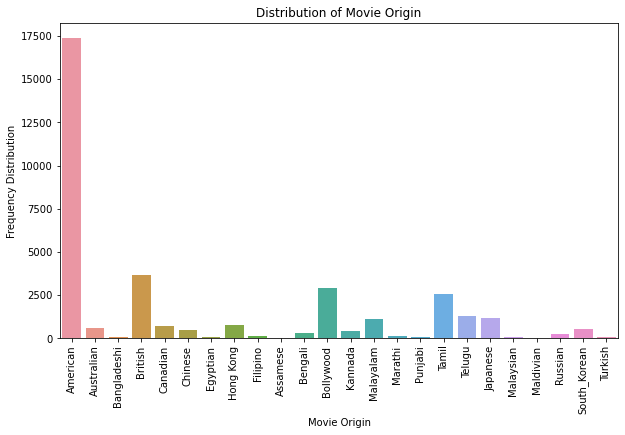

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

sns.countplot(x = wiki['Origin/Ethnicity'])
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('Distribution of Movie Origin')
plt.xlabel('Movie Origin')
plt.ylabel('Frequency Distribution')
fig.savefig('./images/FreqDistOrigin.png');

## Subsetting the dataset to include only the entries with a known genre and resetting the index

In [8]:
wiki_df = wiki.loc[wiki['Genre']!='unknown']
wiki_df.reset_index(drop = True, inplace = True)

Checking the number of unique values we have in the genres column

In [9]:
genres=pd.value_counts(wiki_df.Genre)

print('There are ',len(genres), 'different Genres in the dataset:')
print('-'*50)
print(genres)

There are  2264 different Genres in the dataset:
--------------------------------------------------
drama                                               5964
comedy                                              4379
horror                                              1167
action                                              1098
thriller                                             966
                                                    ... 
sports/social                                          1
korean war                                             1
bholenath movies & cinekorn entertainment              1
animation                                              1
drama, sports (aquatics, swimming), comedy-drama       1
Name: Genre, Length: 2264, dtype: int64


## Getting the top 6 most commonly occuring genres in the dataset

In [10]:
top_genres = pd.DataFrame(genres[:6]).reset_index()
top_genres.columns = ['genres', 'number_of_movies']
top_genres

,genres,number_of_movies
0,drama,5964
1,comedy,4379
2,horror,1167
3,action,1098
4,thriller,966
5,romance,923


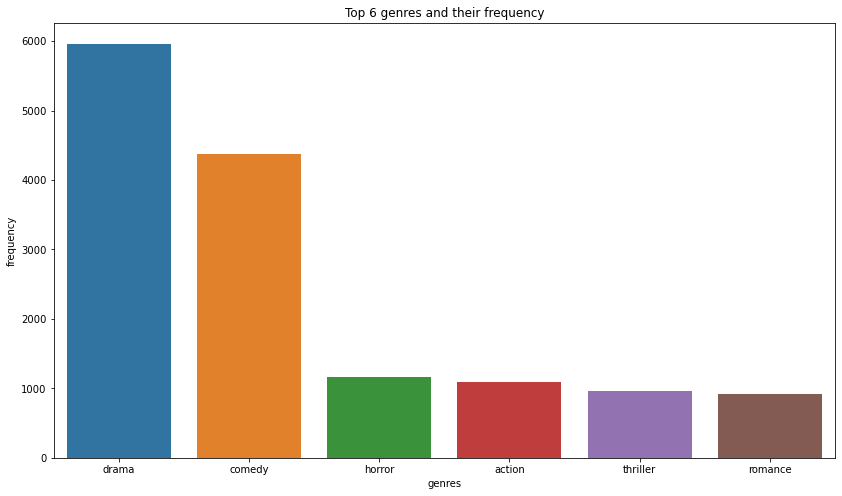

In [11]:
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(top_genres['genres'], top_genres['number_of_movies'])
plt.title('Top 6 genres and their frequency')
plt.xlabel('genres')
plt.ylabel('frequency')
fig.savefig('./images/freqoftopgenres.png')

## Creating separate labels column for the top 6 genres only and assigning the values between 1-6 for drama, comedy,horror, action, thriller and romance, respectively if present in the genre column of the movie (for entries that have only one genre)

In [12]:
conditions = [wiki_df['Genre']=='drama', wiki_df['Genre']=='comedy', wiki_df['Genre']=='horror', wiki_df['Genre']=='action', wiki_df['Genre']=='thriller',
             wiki_df['Genre']=='romance']
choices = [1,2,3,4,5,6]
wiki_df['labels'] = np.select(conditions, choices, 0)

In [13]:
wiki_df.sample(6)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
23578,1987,Imaandaar,Bollywood,Sushil Malik,"Sanjay Dutt, Farha Naaz, Pran","action, crime, drama",https://en.wikipedia.org/wiki/Imaandaar,Raju (Sanjay Dutt) is an orphan. He has been b...,0
16350,2013,Welcome to the Jungle,American,Rob Meltzer,"Jean-Claude Van Damme, Adam Brody, Rob Huebel,...",comedy,https://en.wikipedia.org/wiki/Welcome_to_the_J...,An office team go on a two-day team-building s...,2
1705,1934,Now I'll Tell,American,Edwin J. Burke,"Spencer Tracy, Helen Twelvetrees, Alice Faye",drama,https://en.wikipedia.org/wiki/Now_I%27ll_Tell,Murray Golden is an unscrupulous New York City...,1
1885,1935,Murder in the Fleet,American,Edward Sedgwick,"Robert Taylor, Arthur Byron, Una Merkel","comedy, drama",https://en.wikipedia.org/wiki/Murder_in_the_Fleet,Captain John Winslow (Arthur Byron) is notifie...,0
1855,1935,The Irish in Us,American,Lloyd Bacon,"James Cagney, Pat O'Brien, Olivia de Havilland",comedy,https://en.wikipedia.org/wiki/The_Irish_in_Us,"In Manhattan's lower east side, police officer...",2
4482,1947,Riffraff,American,Ted Tetzlaff,"Pat O'Brien, Walter Slezak",film noir,https://en.wikipedia.org/wiki/Riffraff_(1947_f...,"A cargo plane leaves Peru, bound for Panama wi...",0


In [14]:
wiki_df['labels'].value_counts()

0    14306
1     5964
2     4379
3     1167
4     1098
5      966
6      923
Name: labels, dtype: int64

## Subsetting the wiki_df dataframe to only include the rows that have entries (1-6) in the newly created labels columns (the ones that have only a single genre entry)

In [15]:
 df_to_use = (wiki_df.loc[wiki_df['labels']!=0]).reset_index(drop = True)

In [16]:
# We are now left with about 14 thousand rows of data
df_to_use.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,labels
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,2
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,2
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,2
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,1
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,1


Dropping unnecessary columns

In [17]:
df_to_use.drop(columns = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis = 1, inplace = True)

In [18]:
df_to_use.head(2)

,Title,Genre,Plot,labels
0,The Suburbanite,comedy,The film is about a family who move to the sub...,2
1,How Brown Saw the Baseball Game,comedy,Before heading out to a baseball game at a nea...,2


In [19]:
df_to_use.describe()

,labels
count,14497.000000
mean,2.275160
std,1.528956
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


## Cleaning up the 'Plot' column

Below we are just looking at a sample of the plot summary

In [20]:
df_to_use['Plot'][5]

"A young couple decides to elope after being caught in the midst of a romantic moment by the woman's angry father. They make plans to leave, but a thief discovers their plans and hides in their trunk and waits for the right moment to steal their belongings."

Creating our stopwords list and adding some cmore words that are very common in the summaries. (I ran the freqdist after this and noticed that some of these words were very common but didn't lend us too much meaning so I came back here to add them to the stopwords list). Changing the text to lower case, removing all the stopwords in our list, stripping unnecessary space and replacing some patterns in our text

In [21]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

Rechecking the summary we looked at above to see if our function worked

In [22]:
df_to_use['Plot'] = df_to_use['Plot'].map(lambda x : clean_text(x))
df_to_use['Plot'][5]

'young couple decides elope caught midst romantic moment woman angry father make plans leave thief discovers plans hides trunk waits right moment steal belongings'

## More EDA

### Distribution of words in plot and movie title for each genre

DRAMA

Frequency Distribution plot showing the 20 most common words in the plot summaries in drama

We can see from the plot that the most common words have to do with family, life, love, etc 

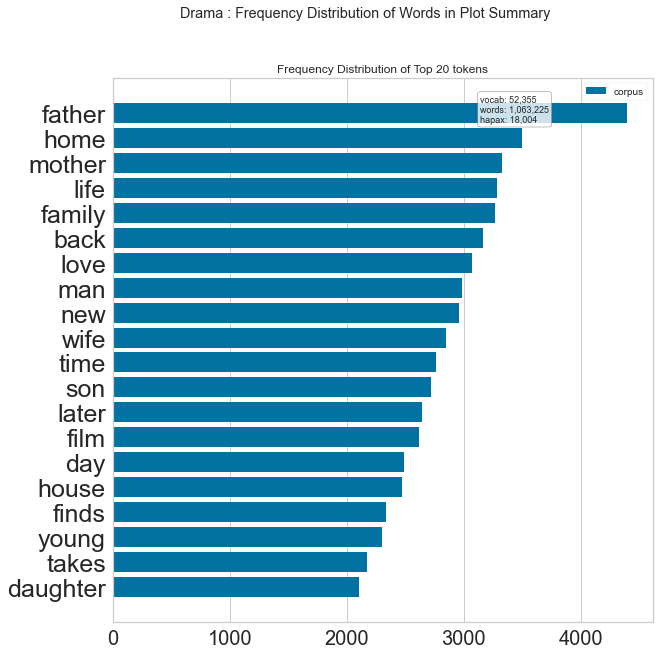

In [47]:
drama_plot = df_to_use.loc[df_to_use['labels'] == 1, ['Plot', 'Title']]
drama_plotlist = [x for x in drama_plot['Plot'].str.split()]
drama_plotlist = list(itertools.chain(*drama_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(drama_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Drama : Frequency Distribution of Words in Plot Summary')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=20, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryfordramagenre');

The wordcloud below shows the same thing above

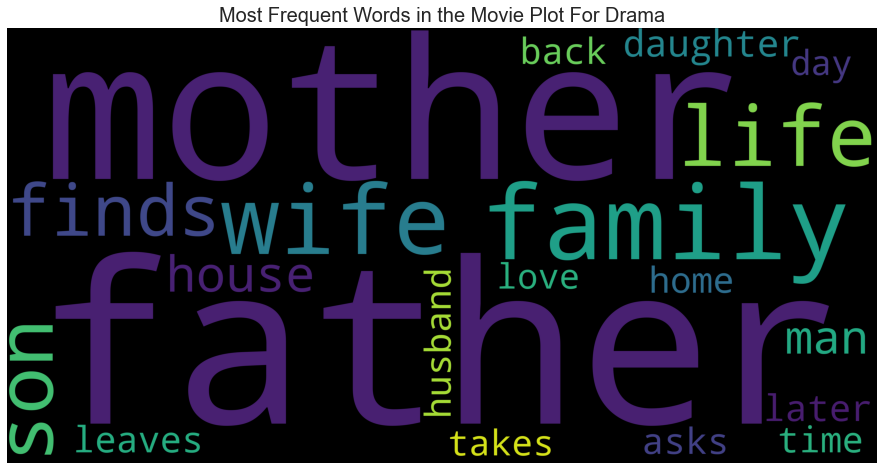

In [48]:
plot_corpus = ' '.join(drama_plot['Plot'])
plot_wordcloud = WordCloud(stopwords=stopwords_list, background_color='black', max_words = 20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Drama', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudDrama.png');

A worldcloud showing the most frequent words in movie titles for drama

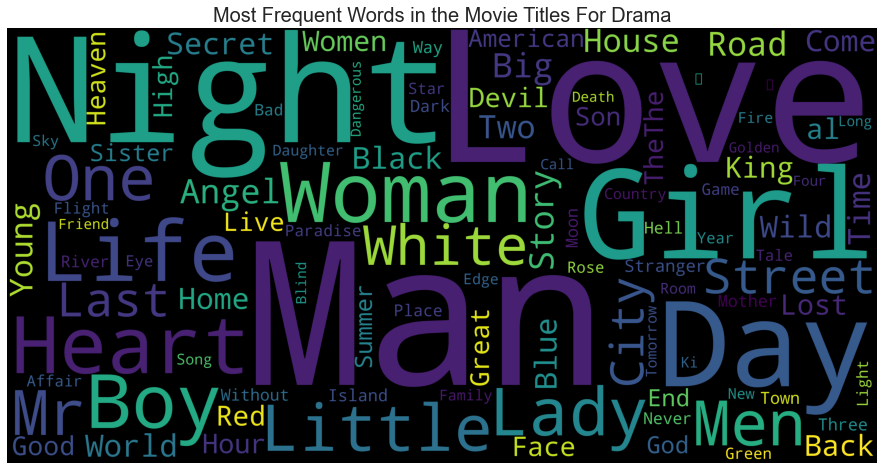

In [49]:
title_corpus = ' '.join(drama_plot['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Drama', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudDrama.png');

COMEDY

Frequency Distribution plot showing the 20 most common words in the plot summaries in comedy

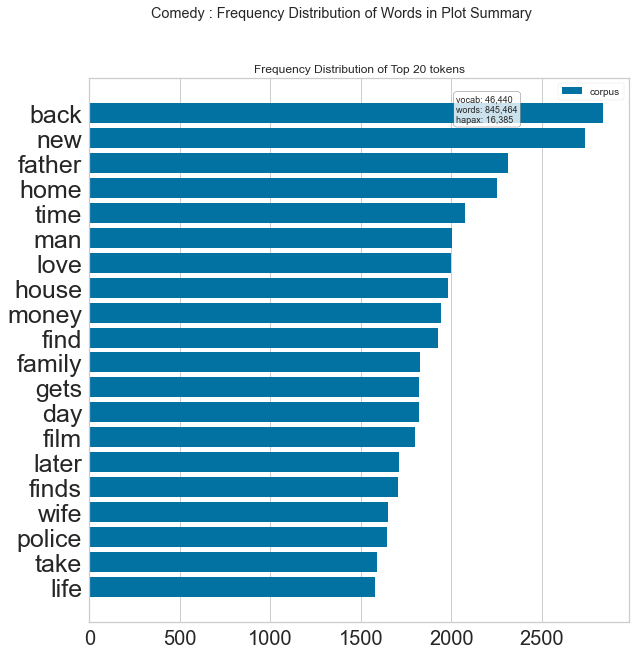

In [46]:
comedy_plot = df_to_use.loc[df_to_use['labels'] == 2, ['Plot', 'Title']]
comedy_plotlist = [x for x in comedy_plot['Plot'].str.split()]
comedy_plotlist = list(itertools.chain(*comedy_plotlist))


count = CountVectorizer()
docs       = count.fit_transform(comedy_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Comedy : Frequency Distribution of Words in Plot Summary')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=20, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforcomedygenre');

The wordcloud below shows the same thing above for comedy

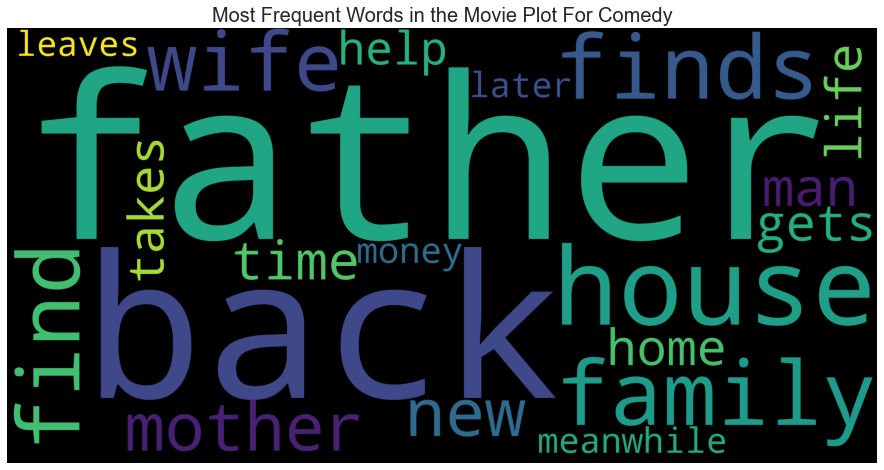

In [50]:
plot_corpus = ' '.join(comedy_plot['Plot'])
plot_wordcloud = WordCloud(stopwords=stopwords_list, background_color='black', max_words = 20, height=2000, width=4000, random_state = 42, 
                          normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Comedy', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudComedy.png');

A worldcloud showing the most frequent words in movie titles for comedy

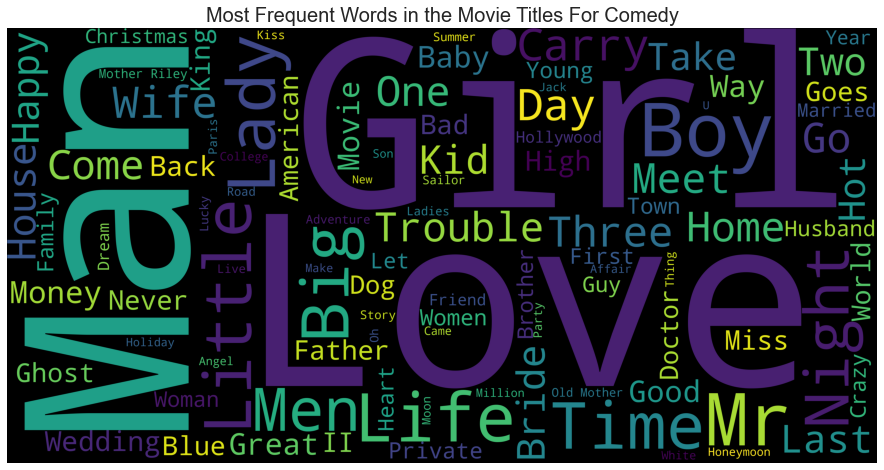

In [51]:
title_corpus = ' '.join(comedy_plot['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Comedy', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudComedy.png');

HORROR

Frequency Distribution plot showing the 20 most common words in the plot summaries in horror. Words like kill, deadly and body appear to be very common

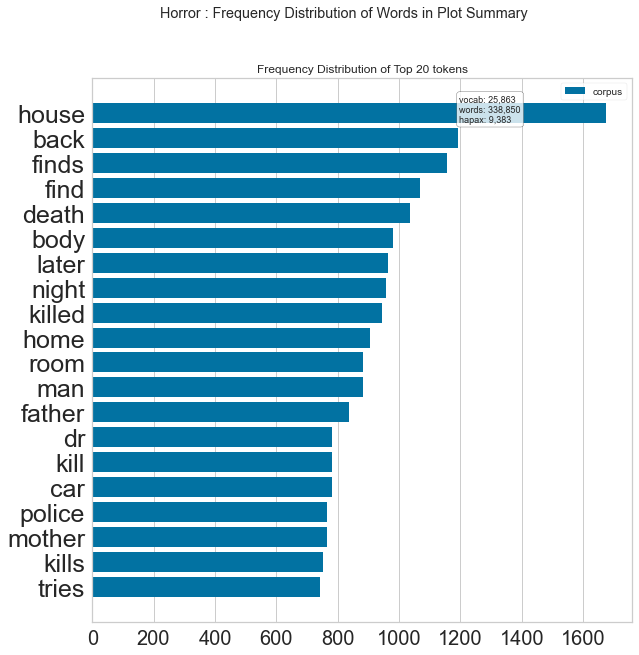

In [45]:
horror_plot = df_to_use.loc[df_to_use['labels'] == 3, ['Plot','Title']]
horror_plotlist = [x for x in horror_plot['Plot'].str.split()]
horror_plotlist = list(itertools.chain(*horror_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(horror_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Horror : Frequency Distribution of Words in Plot Summary')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=20, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforhorrorgenre');

The wordcloud below shows the same thing above for horror

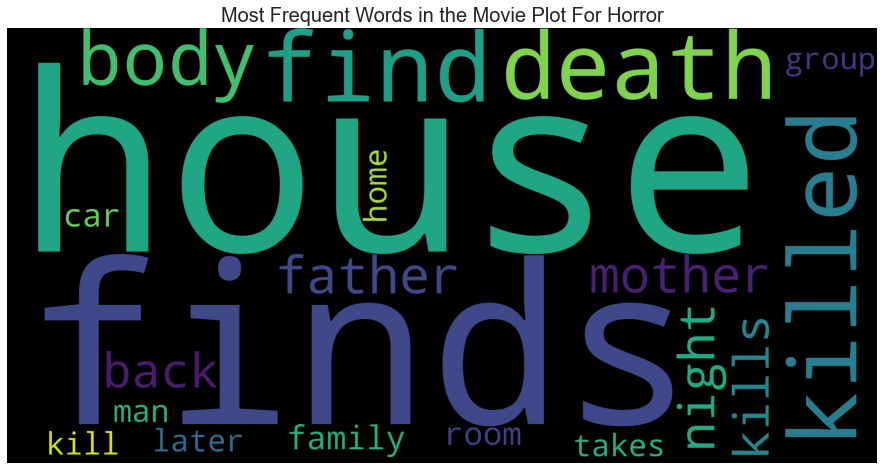

In [52]:
plot_corpus = ' '.join(horror_plot['Plot'])
plot_wordcloud = WordCloud(stopwords=stopwords_list, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Horror', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudHorror.png');

A worldcloud showing the most frequent words in movie titles for horror

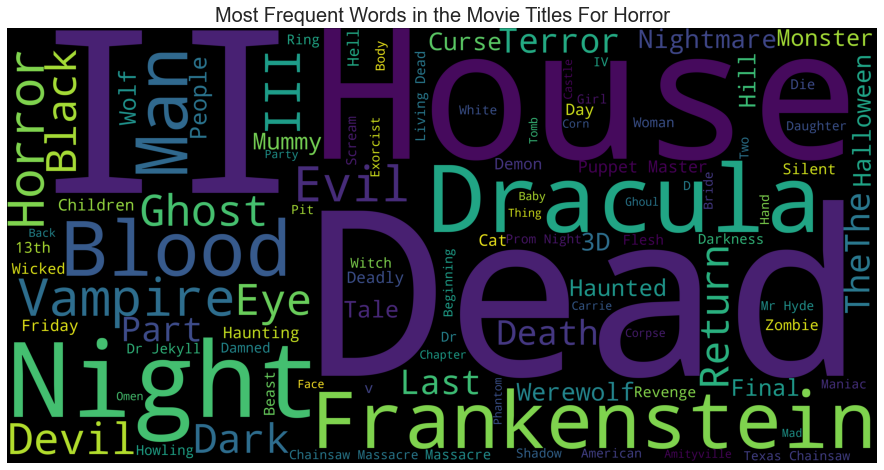

In [53]:
title_corpus = ' '.join(horror_plot['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Horror', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudHorror.png');

ACTION

Frequency Distribution plot showing the 20 most common words in the plot summaries in action

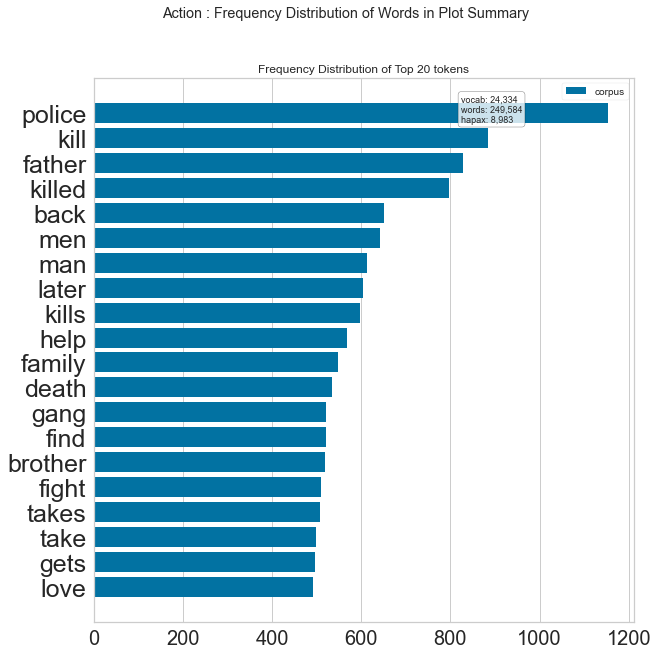

In [42]:
action_plot = df_to_use.loc[df_to_use['labels'] == 4, ['Plot', 'Title']]
action_plotlist = [x for x in action_plot['Plot'].str.split()]
action_plotlist = list(itertools.chain(*action_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(action_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Action : Frequency Distribution of Words in Plot Summary')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=20, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforactiongenre');

The wordcloud below shows the same thing above for action

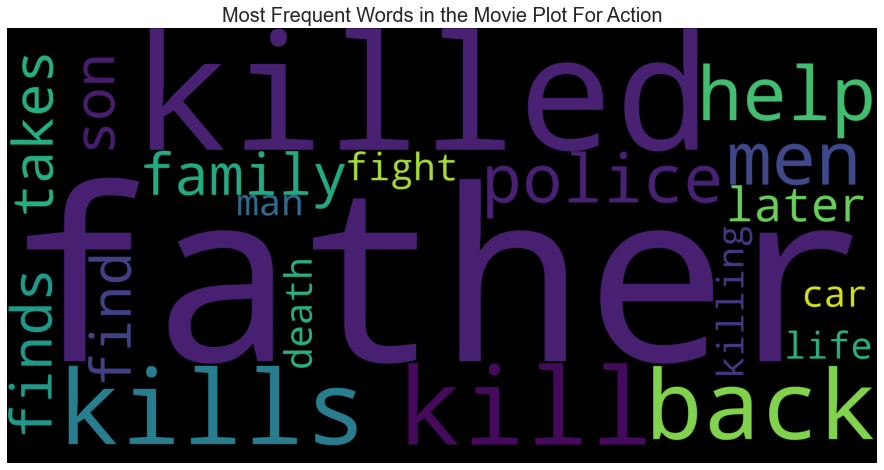

In [54]:
plot_corpus = ' '.join(action_plot['Plot'])
plot_wordcloud = WordCloud(stopwords=stopwords_list, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Action', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudAction.png');

A worldcloud showing the most frequent words in movie titles for action

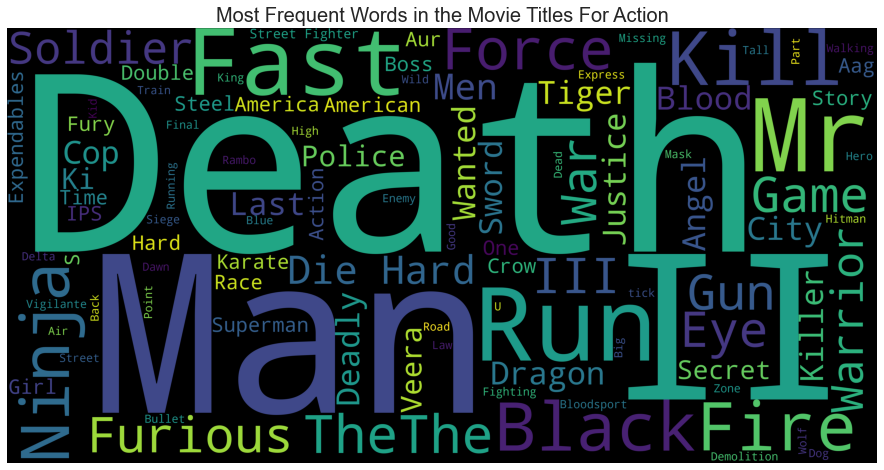

In [55]:
title_corpus = ' '.join(action_plot['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Action', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudAction.png');

THRILLER

Frequency Distribution plot showing the 20 most common words in the plot summaries in thriller

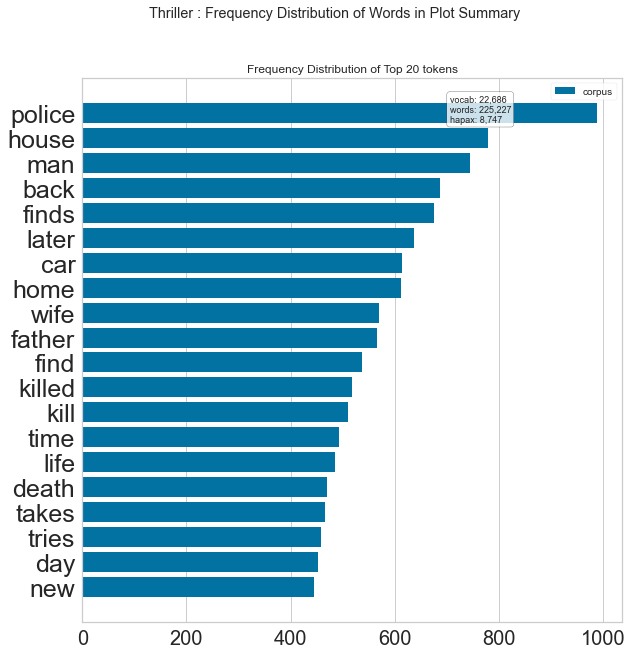

In [43]:
thriller_plot = df_to_use.loc[df_to_use['labels'] == 5, ['Plot', 'Title']]
thriller_plotlist = [x for x in thriller_plot['Plot'].str.split()]
thriller_plotlist = list(itertools.chain(*thriller_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(thriller_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Thriller : Frequency Distribution of Words in Plot Summary')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=20, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforthrillergenre');

The wordcloud below shows the same thing above for thriller

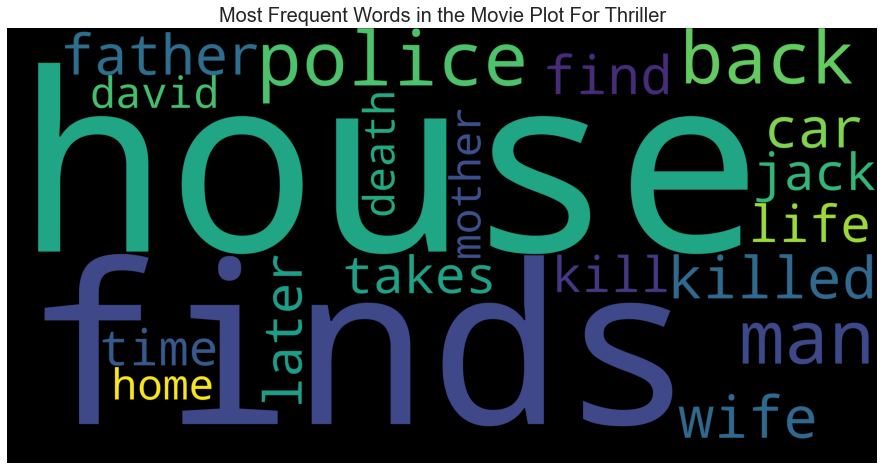

In [56]:
plot_corpus = ' '.join(thriller_plot['Plot'])
plot_wordcloud = WordCloud(stopwords=stopwords_list, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Thriller', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudThriller.png');

A worldcloud showing the most frequent words in movie titles for thriller

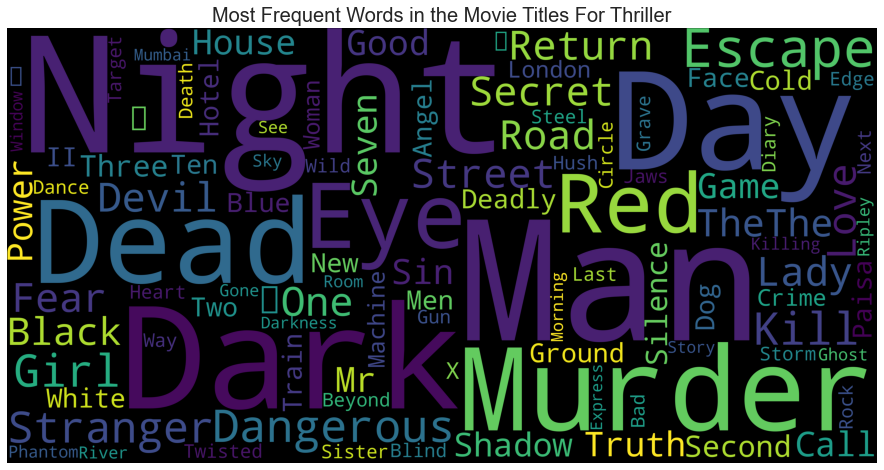

In [57]:
title_corpus = ' '.join(thriller_plot['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Thriller', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudThriller.png');

ROMANCE

Frequency Distribution plot showing the 20 most common words in the plot summaries in romance

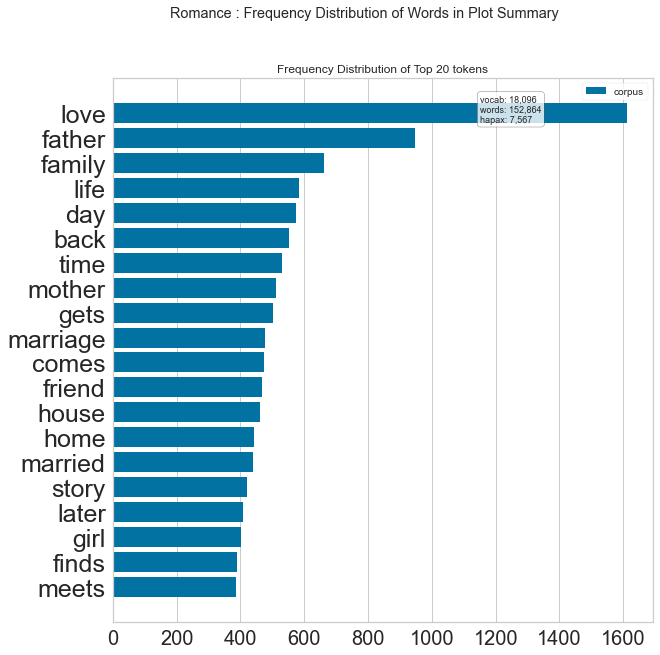

In [44]:
romance_plot = df_to_use.loc[df_to_use['labels'] == 6, ['Plot', 'Title']]
romance_plotlist = [x for x in romance_plot['Plot'].str.split()]
romance_plotlist = list(itertools.chain(*romance_plotlist))

count = CountVectorizer()
docs       = count.fit_transform(romance_plotlist)
features   = count.get_feature_names()


fig = plt.figure(figsize=(10, 10))
plt.suptitle('Romance : Frequency Distribution of Words in Plot Summary')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 20)
plt.gcf().subplots_adjust(left=0.15)

visualizer = FreqDistVisualizer(features = features, n=20, orient='h')
visualizer.fit(docs)
visualizer.show()
fig.savefig('./images/freqdistofwordsinplotsummaryforromancegenre');

The wordcloud below shows the same thing above for romance

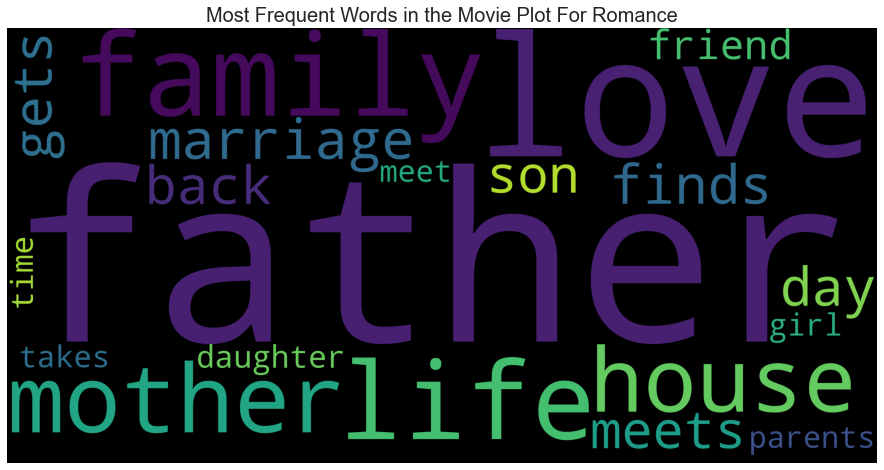

In [58]:
plot_corpus = ' '.join(romance_plot['Plot'])
plot_wordcloud = WordCloud(stopwords=stopwords_list, background_color='black', max_words=20, height=2000, width=4000, random_state = 42, 
                           normalize_plurals = False).generate(plot_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Plot For Romance', fontsize = 20)
plt.show()
fig.savefig('./images/MoviePlotCloudRomance.png');

A worldcloud showing the most frequent words in movie titles for romance

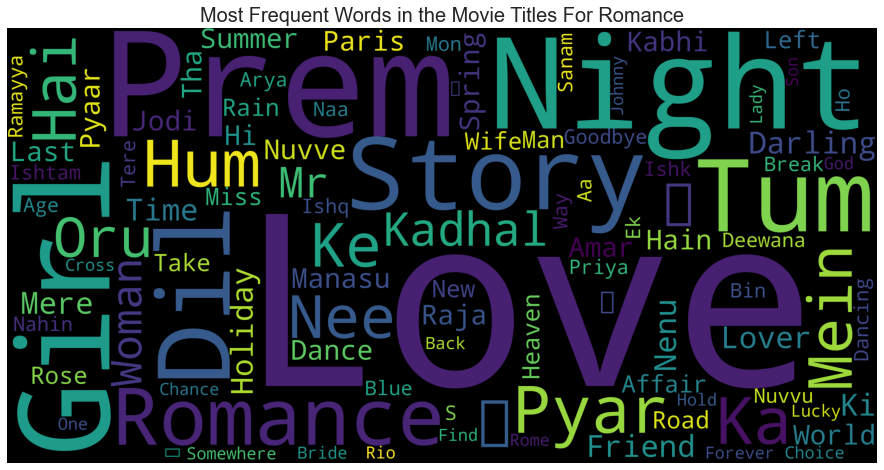

In [59]:
title_corpus = ' '.join(romance_plot['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles For Romance', fontsize = 20)
plt.show()
fig.savefig('./images/MovieTitleCloudRomance.png');

# Modeling

## Assigning Independent and Target Variables and performing train test split into training and testing set

In [28]:
X = df_to_use['Plot']
y = df_to_use['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10872,) (3625,) (10872,) (3625,)


## First simple Model using Dummy Classifier

Dummy Classifier just predicting the most frequent class in the dataset gives us a 41% accuracy and we are going to be using that as our baseline accuracy moving forward

In [32]:
dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
dummy_gs = GridSearchCV(dummy, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.4114238704015058


## Using TfidfVectorizer on the independent variable and testing out the Multinomial Naive Bayes Model and Logistic Regression Model

In [33]:
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15)
tfidf_Xtr = vectorizer.fit_transform(X_train)

In [35]:
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_tfidf_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
mnb_tfidf_gs.fit(tfidf_Xtr, y_train)
print(mnb_tfidf_gs.best_score_)

0.6195741945034843


In [44]:
lr_grid = {
    'penalty' : ['l1', 'l2', 'none'],
    'C' : [1.0, 1e2, 1e4, 1e10],
    'class_weight' : ['balanced', None],
    'solver' : ['lbfgs', 'liblinear'],
    'multi_class' : ['ovr', 'multinomial']
}
logreg = LogisticRegression(random_state = 42)
logreg_tfidf_gs = GridSearchCV(logreg, param_grid = lr_grid, cv = 5)
logreg_tfidf_gs.fit(tfidf_Xtr, y_train)
print(logreg_tfidf_gs.best_score_)

0.63336987807844


## Using Count Vectorizer on the independent variable with theMultinomial Naive Bayes Model and Logistic Regression Model

In [37]:
countvec = CountVectorizer(ngram_range = (1,3), max_features = 30000)
vec_Xtr = countvec.fit_transform(X_train)

In [38]:
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_cvec_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 5)
mnb_cvec_gs.fit(vec_Xtr, y_train)
print(mnb_cvec_gs.best_score_)

0.6029240871744441


The Logisitic Regression model also did a good job on the validation set and gave us an accuracy score of 59% using the countvectorizer transformed text

In [45]:
lr_grid = {
    'penalty' : ['l1', 'l2', 'none'],
    'C' : [1.0, 1e2, 1e4, 1e10],
    'class_weight' : ['balanced', None],
    'solver' : ['lbfgs', 'liblinear'],
    'multi_class' : ['ovr', 'multinomial']
}
logreg = LogisticRegression(random_state = 42)
logreg_cvec_gs = GridSearchCV(logreg, param_grid = lr_grid, cv = 5)
logreg_cvec_gs.fit(vec_Xtr, y_train)
print(logreg_cvec_gs.best_score_)

0.612489970286246


Implementing grid search with decision tree and random forest did not yeild any favorable results while also taking too long to rum. Both had accuracy score hovering around 42%. They have been commented out but can be uncommented and run if desired.

In [48]:
# grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 2, 5, 10],
#     'min_samples_split': [1, 5, 10, 20]
# }

# dt_clf = DecisionTreeClassifier (random_state = 42)
# gs_tree = GridSearchCV(dt_clf, param_grid = grid, cv = 5)
# gs_tree.fit(vec_Xtr, y_train)

# gs_tree.best_params_

# gs_tree.best_score_

In [49]:
# gridrf = {
#     'n_estimators': [100,200,300],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 10,20,25],
#     'min_samples_split': [1, 5, 10, 20]
# }
# rf_clf = RandomForestClassifier (random_state = 42)
# gs_rf = GridSearchCV(rf_clf, param_grid = gridrf, cv = 5)
# gs_rf.fit(vec_Xtr, y_train)

# gs_rf.best_params_

# gs_rf.best_score_

## Using the best model on the test set

The best model is the one that gave us the best score above which is the logistic regression model (logreg_tfidf_gs)on the tfidf-transformed X variable which gave us an accuracy score of approximately 63.3%. Using the '.best_params_' attribute of GridSearchCV, I will obtain the optimal hyparameter values and use it in evaluating the test set.

In [46]:
logreg_tfidf_gs.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}

              precision    recall  f1-score   support

           1       0.69      0.69      0.69      1491
           2       0.69      0.66      0.68      1095
           3       0.71      0.79      0.75       292
           4       0.51      0.59      0.54       275
           5       0.35      0.29      0.32       241
           6       0.42      0.45      0.43       231

    accuracy                           0.64      3625
   macro avg       0.56      0.58      0.57      3625
weighted avg       0.64      0.64      0.64      3625



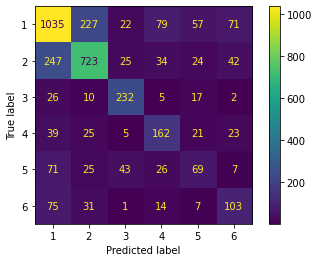

In [47]:
logreg_pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range = (1,1), max_df=.85, min_df=15)),
                ('clf', LogisticRegression(C = 1.0, class_weight = 'balanced', multi_class = 'ovr', penalty = 'l2', solver = 'liblinear', random_state = 42)),
               ])
logreg_pipeline.fit(X_train, y_train)
y_hat = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_hat))
plot_confusion_matrix(logreg_pipeline, X_test, y_test)

# Conclusion

When evaluating all the models, the decision tree and random forest models performed least favorably and although the other models performed okay, the Logistic Regression Model performed best when used on the tfidf-transformed X variable. GridSearchCV helped in narrowing down the best hyperparameter values.
When the model was applied to the test set, a 64% accuracy was achieved. This is a significant increase from the baseline accuracy of 41% when during cross validation!